# Шаг 1. Загрузим данные и подготовим их к анализу


## Описание проекта

Нам предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

display(visits.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [5]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
# преобразование данных о времени

visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [7]:
# поиск дубликатов

display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

0

0

0

### Вывод:

1) У нас для анализа данные о визитах, заказах и рекламных тратах в трех таблицах.

2) В каждой из таблиц есть данные о времени (начало и окончание сессий, дата покупки, дата проведения рекламной кампании). Мы привели данные в этих столбцах к соответствующему типу - datetime

3) Проверили отсутствие дубликатов строк.

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Для создания пользовательских профилей с датой первого посещения и источником перехода на сайт напишем функцию get_profiles(). В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию first():

In [8]:
def get_profiles(visits): 

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения Session Start и Channel
    # столбец с временем первого посещения назовём first_ts
   
    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg({'Session Start': 'first', 'Channel': 'first'})
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()  # возвращаем User Id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
   
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles

Напишем функцию для расчёта коэффициента удержания get_retention().

In [9]:
def get_retention(profiles, visits, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(visits[['User Id', 'Session Start']], on = 'User Id', how = 'left')
    result_raw['lifetime'] = (result_raw['Session Start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'User Id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'User Id': 'nunique'}).rename(columns = {'User Id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные
    return result_raw, result_grouped, result_in_time

Зададим функцию для расчета конверсии зарегистрировавшихся пользователей в платящих.

In [10]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['User Id', 'Event Dt'])
        .groupby('User Id')
        .agg({'Event Dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['User Id', 'Event Dt']], on='User Id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Зададим функцию для расчета "пожизненной ценности клиентов" get_ltv().

In [11]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['User Id', 'Event Dt', 'Revenue']], on='User Id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='Revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим функцию для построения графика удержания платящих и неплатящих пользователей plot_retention().

In [12]:
def plot_retention(retention):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.show()

Напишем аналогичную функцию и для визуализации конверсии — plot_conversion(). Результатом её вызова будут два графика: кривые и динамика. Разделение на платящих и неплатящих пользователей в контексте конверсии не имеет смысла.
Также зададим функцию filter_data для сглаживания фрейма окном.

In [13]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Напишем функцию для визуализации пожизненной ценности и окупаемости — plot_ltv_roi(). Графики, отражающие динамику метрик, сгладим функцией filter_data()

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

## 3.1. Создадим пользовательские профили. Определим минимальную и максимальную даты привлечения пользователей.

In [16]:
profiles = get_profiles(visits)
profiles.head()

,User Id,first_ts,Channel,dt,month
0,599326,2019-05-07 20:58:57,FaceBoom,2019-05-07,2019-05-01
1,4919697,2019-07-09 12:46:07,FaceBoom,2019-07-09,2019-07-01
2,6085896,2019-10-01 09:58:33,organic,2019-10-01,2019-10-01
3,22593348,2019-08-22 21:35:48,AdNonSense,2019-08-22,2019-08-01
4,31989216,2019-10-02 00:07:44,YRabbit,2019-10-02,2019-10-01


In [17]:
first_visit = profiles['first_ts'].sort_values().head(1) # минимальная дата привлечения пользователей
display(first_visit)

last_visit = profiles['first_ts'].sort_values().tail(1) # максимальная дата привлечения пользователей
last_visit

57600   2019-05-01 00:00:41
Name: first_ts, dtype: datetime64[ns]

111023   2019-10-27 23:59:04
Name: first_ts, dtype: datetime64[ns]

### Вывод:

1) Мы получили 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике, который мотивировал пользователя посетить интернет-магазин.

2) Минимальная дата привлечения пользователя - 01 мая 2019 г. Максимальная - 27 октября 2019г

## 3.2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны

In [18]:
# добавим второй аргумент, чтобы профили пользователей также имели информацию о покупках
def get_profiles(visits, orders):

    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'])# ваш код здесь

    return profiles

In [19]:
# строим профили по двум наборам данных
users = get_profiles(visits, orders)

users.groupby('Region').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False)

,payer
Region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


### Вывод:

1) Пользователи приходят в приложение из 4 стран: Великобритании, Германии, США и Франции.

2) Наибольшая доля платящих пользователей приходится на США - почти 7%, наименьшая же - 3,7% на Францию.

## 3.3. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства

In [20]:
users.groupby('Device').agg({'User Id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,User Id,payer
Device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


### Вывод:

1) Пользователи пользуются приложением с четырех устройств - Мас, смартфоны iPhone и Andriod, а также с компьютера или ноутбука (РС).

2) Большинство платяжщих пользователей приходит с устройств Мас и iPhone.

## 3.4. Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения

In [21]:
users.groupby('Channel').agg({'User Id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,User Id,payer
Channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


### Вывод:

1) Пользователи приходят в приложение из 11 рекламных источников. Основные источники, пользователи которых наибольшим образом конвертируются в платящих - это FaceBoom, AdNonSense и lambdaMediaAds.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

## 4.1. Посчитаем общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируем изменения метрик во времени

In [22]:
full_cost = costs['costs'].sum() # считаем суммарные траты на рекламу
full_cost

105497.30000000002

In [23]:
costs.groupby('Channel').agg('sum').assign(pct_total=lambda x: (x / x.sum()) * 100).sort_values(by='costs', ascending=False)
# определяем как траты распределены по источникам


,costs,pct_total
Channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


Визуализируем изменения метрик во времени.

In [24]:
costs['month'] = costs['dt'].dt.month

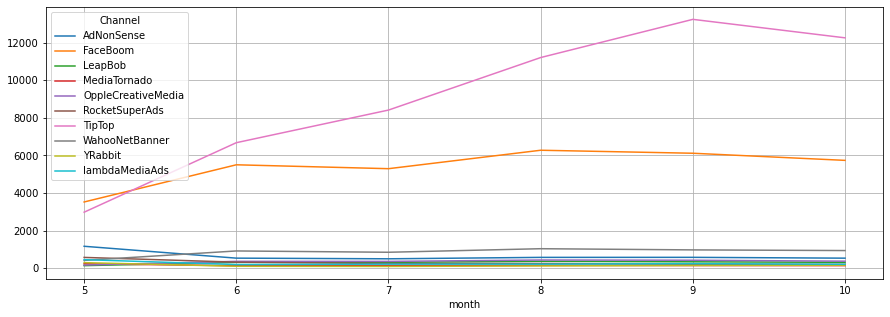

In [25]:
costs.pivot_table(
    index='month',  # группируем по месяцам
    columns='Channel',  # источники переходов
    values='costs',  # траты на маркетинг
    aggfunc='sum'  # суммарные траты за месяц
).plot(figsize=(15, 5), grid=True)

plt.show()

### Вывод:

1) За 6 месяцев проведения рекламных кампаний суммарные расходы на маркетинг составили чуть больше 105 тыся у.е.

2) Наибольшая доля приходится на такие каналы привлечения клиентов, как: TipTop, FaceBoom и WahooNetBanner

3) При расчете траты во времени наглядно видно, что единственный источник, траты по маркетингу на который многократно возрасли - это Tip Top. Примечательно, что доля платящих пользователей с этого источника находится всего на 4-ом месте.

## 4.2. Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используем профили пользователей

In [26]:
# преобразуем данные о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [27]:
# добавляем параметр costs — траты на рекламу
def get_profiles(visits, orders, costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
         visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()  # возвращаем User Id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())

     # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs = costs.merge(new_users, on=['dt', 'Channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [28]:
profiles = get_profiles(visits, orders, costs)

profiles.head(5)

,User Id,first_ts,Channel,Device,Region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Исключим из расчетов пользователей пришедших органически, так как для их привлечения компания ничего не платила.

In [29]:
profiles = profiles.query('Channel != "organic"')

В профилях появился новый столбец acquisition_cost со стоимостью привлечения каждого посетителя приложения Procrastinate Pro+.

Выясним стоимость привлечения для каждого источника. Для этого построим график, в котором названиями столбцов будут каналы привлечения, а значениями — средний CAC на одного пользователя.

In [30]:
profiles['month'] = pd.to_datetime(profiles['dt']).dt.month

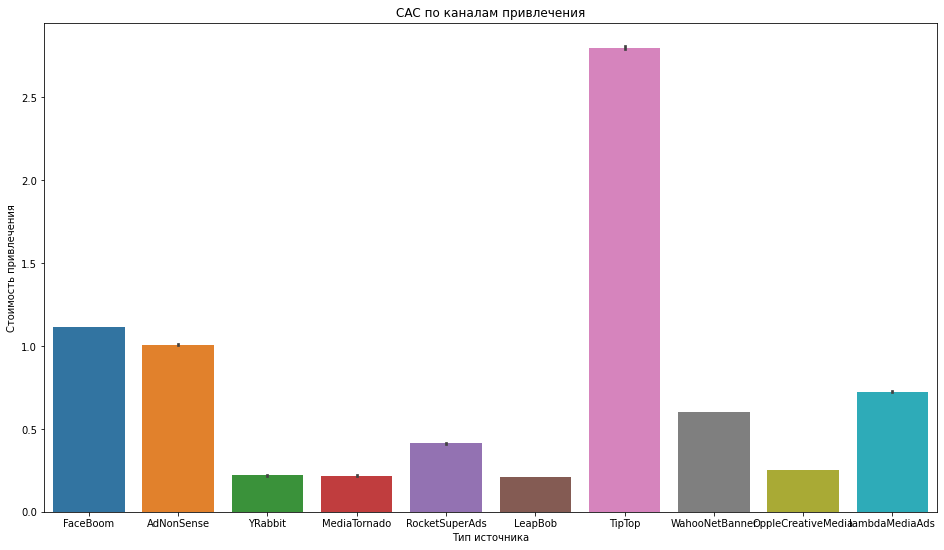

In [31]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="Channel", y="acquisition_cost", data=profiles)
plt.title('CAC по каналам привлечения')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Выведем таблицу САС в разбивке по каждому источнику привлечения, чтобы посмотреть точные значения.

In [32]:
profiles.groupby('Channel').agg({'acquisition_cost':'mean'}).head(10).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
Channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Также рассчитаем средний CAC на одного пользователя для всего проекта.

In [33]:
profiles['acquisition_cost'].mean()

1.127481323942928

### Вывод:

1) Стоимость привлечения «органических» пользователей во всех месяцах равна нулю, потому что они пришли в приложение самостоятельно, а не благодаря рекламе, поэтому исключили их из расчетов. 

2) Сильно выделяется стоимость привлечения клиентов из канала TipTop. За стоимость привлечения клиента из этого источника можно привести двух клиентов из двух других источников (по одному клиенту из каждого). Вероятно, это одна из причн убытков компании.
Компания вкладывает много денег в рекламу в этом источнике. Ниже проверим его конверсию, удержание и окупаемость, чтобы сделать окончательный вывод.

3) Если говорить о стоимости привлечения одного клиента по всему проекту, то она получается 1.13 у.е.
Опять же, средняя стоимость по проекту может быть гораздо ниже, если разобраться с TipTop, так как это единственный источник, который сильно увеличивает ср.стоимость привлечения.

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### 5.1. Проанализируйте общую окупаемость рекламы. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [34]:
# считаем LTV, CAC и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    datetime(2019, 11, 1).date(),
    14,
)

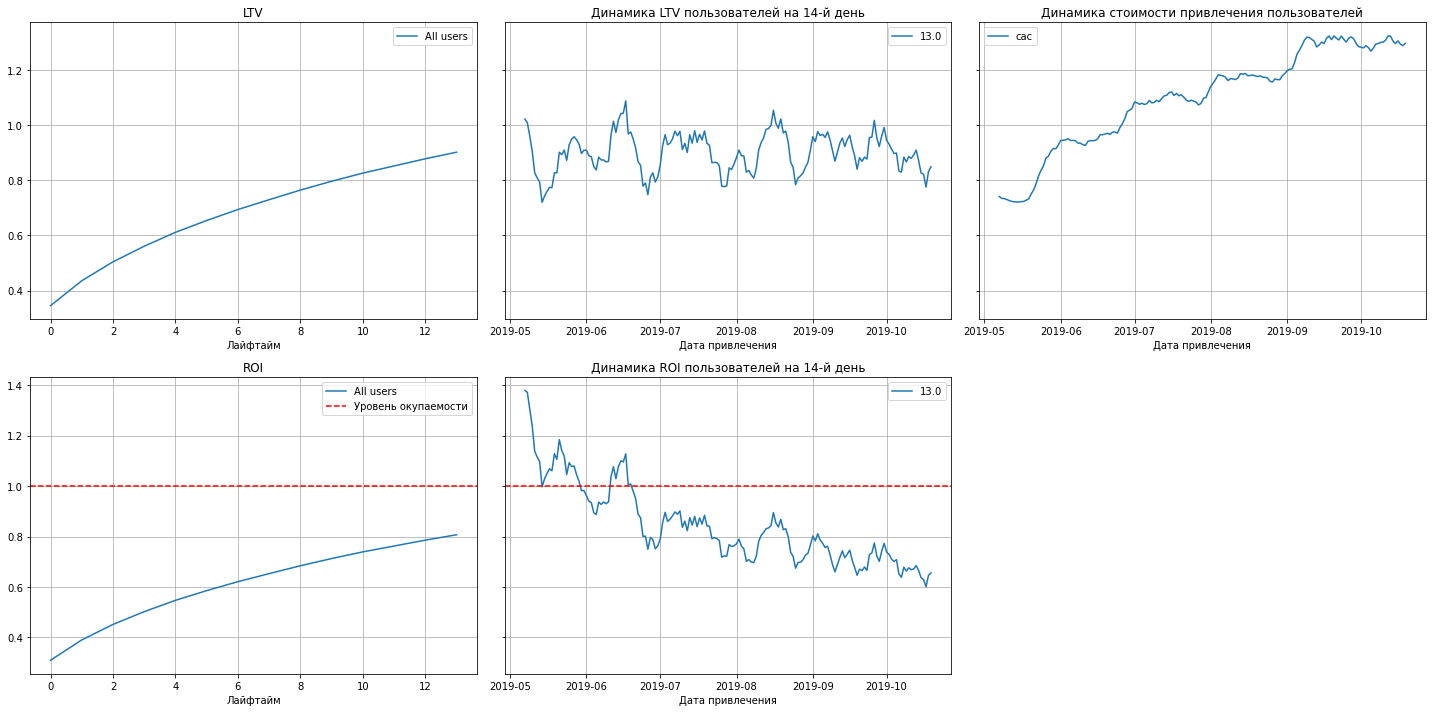

In [35]:
# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

### Вывод:

1) На графиках отчетливо видно провальную окупаемость рекламы. Со временем средняя стоимость привлечения клиента увеличивается почти в 3 раза! На графике ROI мы четко видим, что окупаемость рекламы находится ниже 1, т.е. не окупается.

2) График динамики ROI как раз подтверждает наши предположения, что с течением времени реклама перестала окупаться (т.к. растет стоимость привлечения клиента).

### 5.2. Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [36]:
# считаем LTV, CAC и ROI с разбивкой по каналам привлечения

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Channel'],
)

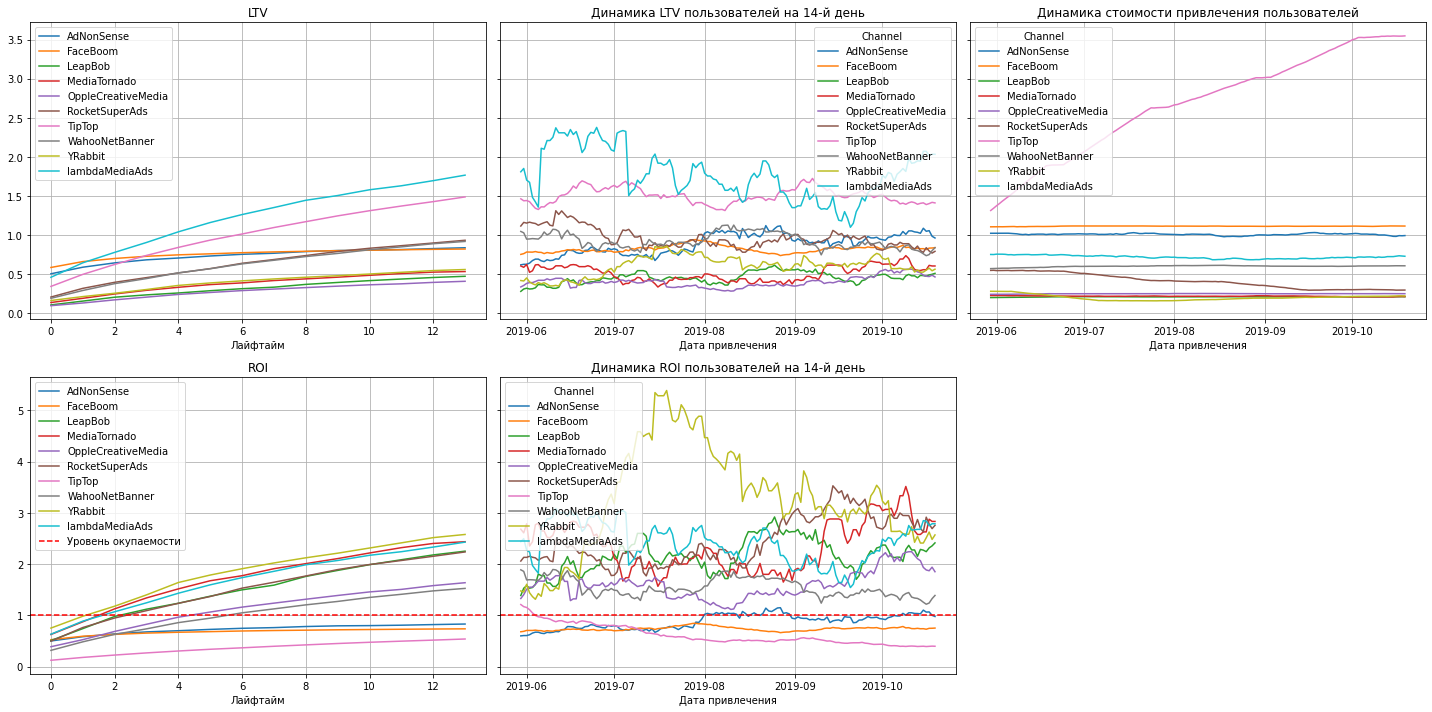

In [37]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=30) # зазадим окно в месяц, чтобы график был наглядно читабельный

### Вывод:

1) Наибольше количество прибыльных клиентов приходит из каналов "lambdaMediaAds" и "TipTop".

2) При этом "TipTop" является самой невыгодной в привлечении клиентов. Это единственный канал, стоимость привлечения клиентов из которого выросла в 3 раза.

3) На графике ROI четко видим, что каналы AdNonSense, FaceBoom и TipTop Не окупаются. Лидерами же по этой статье являются YRabbit и MediaTornado.

### 5.3. Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [38]:
# считаем LTV, CAC и ROI с разбивкой по странам

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Region'],
)

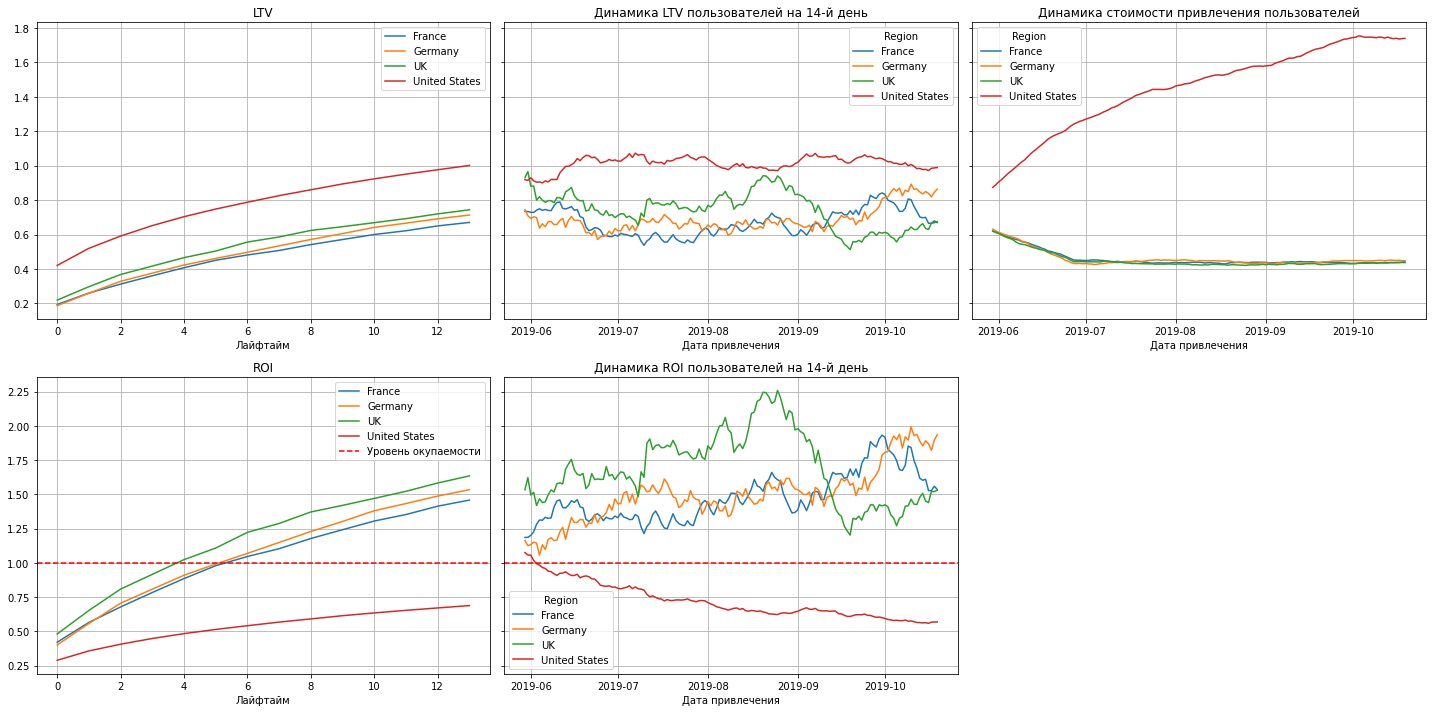

In [39]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=30)

### Вывод:

1) При разбивке по странам ситуация с США аналогичная ситуации с каналом "TipTop". В этой стране клиенты приносят наибольшее кол-во денег компании, однако стоимость привлечения клиентов сильно растет со временем, что сказывается на окупаемости рекламы. Если в начале кампании она еще окупалась (но и то, была ниже всех), то в конце уходит ниже 1.

### 5.3. Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [40]:
# считаем LTV, CAC и ROI с разбивкой по устройствам

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Device'],
)

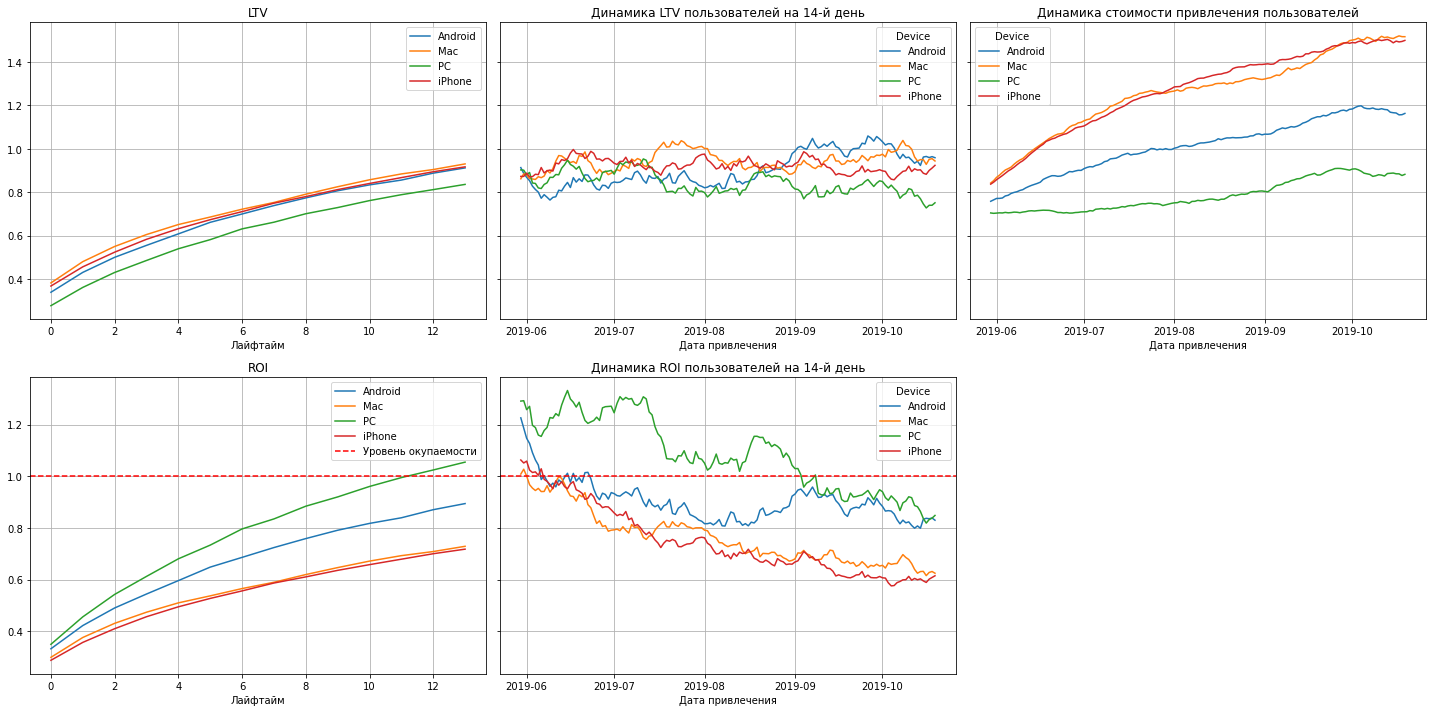

In [41]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=30)

### Вывод:
 
1) При разбивке по устройствам ситуация +/- одинаковая по всем девайсам. Однако, выделяется PC как устройство, по которому чуть ниже стоимость привлечения клиентов и по графику ROI мы видим, что к последнему месяцу анализа реклама на нем даже вышла в "+".
По остальным же устройствам реклама не окупается.

### 5.4. Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

In [42]:
# считаем удержание по устройству
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Device'],
)

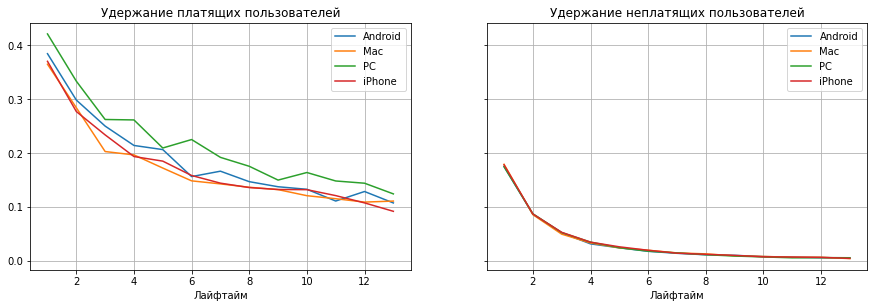

In [43]:
plot_retention(retention)

In [44]:
# считаем удержание по стране
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Region'],
)

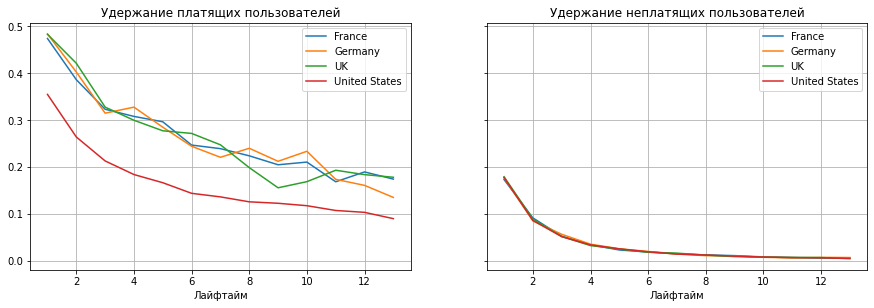

In [45]:
plot_retention(retention)

In [46]:
# считаем удержание по каналу привлечения
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['Channel'],
)

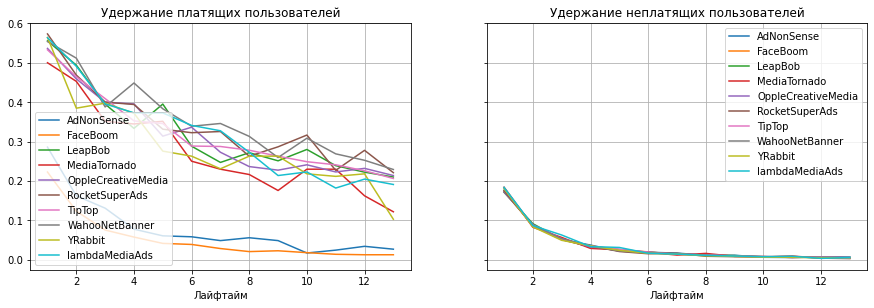

In [47]:
plot_retention(retention)

1) Удержание клиентов из США значительно ниже, чем у клиентов из других стран. Это плохо, так как при этом конверсия у клиентов США самая высокая, с большим отрывом от других стран.

2) В разбивке по устройствам удержание примерно одинаковое, разве что у клиентов PC чуть лучше. Однако, конверсия у клиентов PC самая низкая. В этом случае лучше делать ставку на клиентов Мас и iPhone.

3) Выделяется удержание по двум каналам FaceBoom и AdNonSense. Оно значительно ниже, чем по другим каналам. Для продаж компании это плохая ситуация, так как конверсия (ниже) для этих двум каналов как раз самая высокая.

In [48]:
# считаем конверсию в разбивке по устройствам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['Device'])

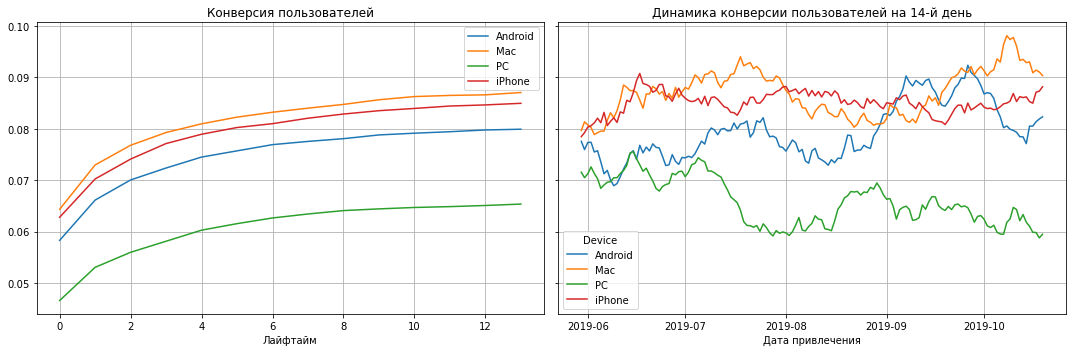

In [49]:
plot_conversion(conversion, conversion_history, 14, window=30)

In [50]:
# считаем конверсию в разбивке по странам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['Region'])

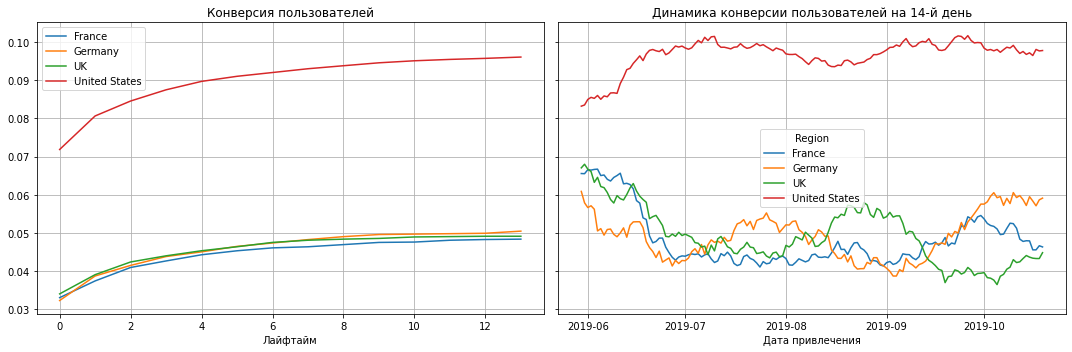

In [51]:
plot_conversion(conversion, conversion_history, 14, window=30)

In [52]:
# считаем конверсию в разбивке по каналам

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['Channel'])

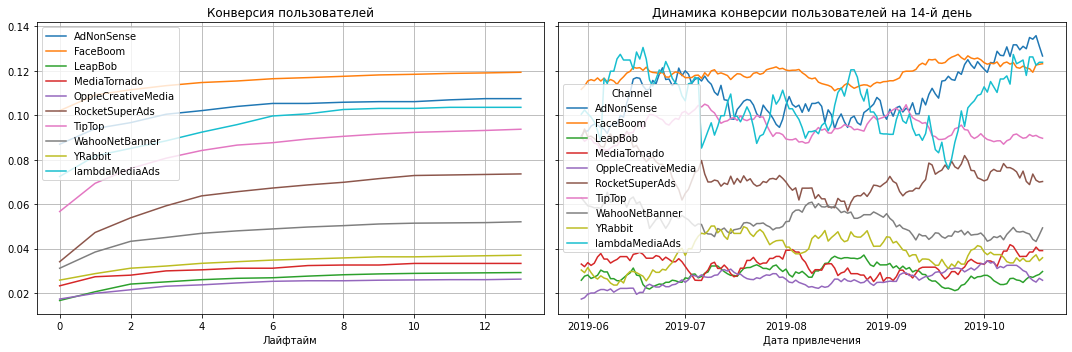

In [53]:
plot_conversion(conversion, conversion_history, 14, window=30)

### Вывод:

1) В разрезе по всем измерениям - устройства, страны, каналы - большинство пользователей неплохо конвертируется, но крайне клохо удерживается. Лидером по конверсии среди стран наглядно можно увидеть США, но при этом эта же страна в лидерах по наименьшему показателю в удержании. Для компании в целом вся эта ситуация плохо сказывается.

2) Лучше всего конвертируются пользователи Mac и iPhone.

3) В развере по каналам по конверсии лидируют каналы AdNonSense и FaceBoom, а также lambdaMediaAds.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

### Вывод:

1) Перед нами стояла задача выяснить причину убытков компании, несмотря на большие вложения в рекламу. 
Мы обнаружили, что страны-лидеры по платящим клиентам - это США, Германия, Великобритания (страны представлены в порядке убывания).
Рейтинг самых "платящих" источников - это FaceBoom, AdNonSense, lambdaMediaAds, TipTop и RocketSuperAds.
При этом топ-источников на затратам на рекламу следующий - TipTop, FaceBoom, WahooNetBanner.

2) Из проведенного анализа таблиц и графиков, можно смело сделать вывод о том, что за представленное время (май-октябрь 2019 года) траты на рекламу из источников FaceBoom и TipTop возрасли многократно (2 и 3 раза соответственно!).

3) В случае с TipTop "ставка" совсем не сыграла, так как клиенты из этого источника находятся не в лидерах по количеству платящих пользователей, а траты на рекламу в нем самые большие из всех.

4) В случае с FaceBoom, клиенты отсюда действительно неплохо покупают, но крайне плохо удерживаются. При этом траты на рекламу в этом источнике стоят вторыми в списке по величине суммы.
Вот как минимум две причины убытков компании.

5) Если говорить про страны, то США приносят наибольшее количество плятящих клиентов, но аналогично FaceBoom очень плохо удерживается. 

6) Рекомендации отделу маркетинга: 
- проверить причину низкого удержания пользователей из FaceBoom и AdNonSense, а также клиентов из США (возможно есть техническая ошибка)
- снизить затраты на рекламу в TipTop
- увеличить рекламу в lambaMediaAds, YRabbit и MediaTornado
- попробовать активизировать рекламу в Германии (т.к. это вторая страна по ковертации, хоть и большим отрывом от США)